In [1]:
# Importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Importing all classification algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Levenshtein import distance as levenshtein_distance
import tldextract
from collections import Counter


In [3]:
df = pd.read_csv("phishing_site_urls.csv")  

In [5]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [7]:
def extract_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}" if extracted.suffix else extracted.domain


In [9]:
df['domain'] = df['URL'].apply(extract_domain)

In [11]:
top_legit_domains = [domain for domain, count in Counter(df['domain']).most_common(50)]

In [13]:
def get_min_levenshtein(url, legit_domains):
    domain = url.split('/')[0]  # Extract main domain
    return min(levenshtein_distance(domain, legit) for legit in legit_domains)

In [15]:
df['levenshtein_distance'] = df['domain'].apply(lambda x: get_min_levenshtein(x, top_legit_domains))


In [19]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
url_vectors = vectorizer.fit_transform(df['URL'])

In [21]:
legit_vectors = vectorizer.transform(top_legit_domains)
df['max_cosine_sim'] = [max(cosine_similarity(url_vectors[i], legit_vectors)[0]) for i in range(df.shape[0])]


In [23]:
# Step 3: Feature Engineering (Lexical & Host-Based Features)
df['url_length'] = df['URL'].apply(len)
df['num_digits'] = df['URL'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special_chars'] = df['URL'].apply(lambda x: sum(c in ['.', '/', '-', '_'] for c in x))
df['num_subdomains'] = df['URL'].apply(lambda x: x.count('.'))
df['has_https'] = df['URL'].apply(lambda x: 1 if 'https' in x.lower() else 0)

In [25]:
df.head()

,URL,Label,domain,levenshtein_distance,max_cosine_sim,url_length,num_digits,num_special_chars,num_subdomains,has_https
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it,7,0.028777,225,58,24,6,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,dghjdgf.com,6,0.036444,81,1,12,5,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com,9,0.026586,177,47,19,7,0
3,mail.printakid.com/www.online.americanexpress....,bad,printakid.com,6,0.185204,60,0,8,6,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com,10,0.047676,116,21,12,1,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   URL                   549346 non-null  object 
 1   Label                 549346 non-null  object 
 2   domain                549346 non-null  object 
 3   levenshtein_distance  549346 non-null  int64  
 4   max_cosine_sim        549346 non-null  float64
 5   url_length            549346 non-null  int64  
 6   num_digits            549346 non-null  int64  
 7   num_special_chars     549346 non-null  int64  
 8   num_subdomains        549346 non-null  int64  
 9   has_https             549346 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 41.9+ MB


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
domain_features = vectorizer.fit_transform(df["domain"])

In [31]:
# Step 4: Convert Labels to Numerical
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

In [33]:
X = df.drop(columns=['Label','URL','domain'])
y = df['Label']

In [35]:
X.head()

,levenshtein_distance,max_cosine_sim,url_length,num_digits,num_special_chars,num_subdomains,has_https
0,7,0.028777,225,58,24,6,0
1,6,0.036444,81,1,12,5,0
2,9,0.026586,177,47,19,7,0
3,6,0.185204,60,0,8,6,0
4,10,0.047676,116,21,12,1,0


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   levenshtein_distance  549346 non-null  int64  
 1   max_cosine_sim        549346 non-null  float64
 2   url_length            549346 non-null  int64  
 3   num_digits            549346 non-null  int64  
 4   num_special_chars     549346 non-null  int64  
 5   num_subdomains        549346 non-null  int64  
 6   has_https             549346 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 29.3 MB


In [39]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int32

In [41]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [45]:
scaler = StandardScaler()
 # Scale the X_train & X_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = {
    'n_estimators': [64,200],  # Number of trees
    'max_depth': [10, 30],  # Maximum depth of trees
    'criterion': ['gini', 'entropy']  # Split criterion
}

In [51]:
model = RandomForestClassifier(random_state=42)

In [53]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

In [55]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 30], 'n_estimators': [64, 200]},
             scoring='accuracy', verbose=2)

In [61]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 200}


In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
cm=confusion_matrix(y_test, y_pred)
cm

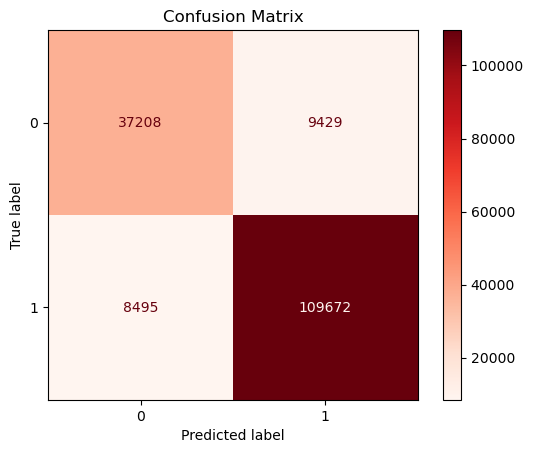

In [145]:
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_matrix.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show();

In [147]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.81      0.80      0.81     46637
        good       0.92      0.93      0.92    118167

    accuracy                           0.89    164804
   macro avg       0.87      0.86      0.87    164804
weighted avg       0.89      0.89      0.89    164804



In [148]:
accuracy = accuracy_score(y_test, y_pred)

In [149]:
accuracy

0.8912405038712653